## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
porp_converted=len(df[df['converted']==True])/len(df)
porp_converted

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
treat_not_new=len(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False])
treat_not_new

3893

f. Do any of the rows have missing values?

In [8]:
null_data = df.isnull().any(axis=1).sum()
null_data

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2=df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)
df2.shape[0]

290585

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated('user_id', keep=False) == True]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2.loc[2893]
#773192	2017-01-14 02:55:59.590927	treatment	new_page	0

user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2893, dtype: object

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(subset ="user_id", inplace = True) 
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
converted_porp=df2.converted.mean()
converted_porp

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
converted_control_porp=df2.query("group=='control'").converted.mean()
converted_control_porp

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
converted_treat_porp=df2.query("group=='treatment'").converted.mean()
converted_treat_porp

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
new_page_porp=len(df2[df2['landing_page']=='new_page'])/len(df2)
new_page_porp

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

the difference between conversion ratio of treatment group and control group is negligable, hence there's no sufficent evidence the new page lead to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### H0 (null) -> Pnew <= Pold
#### H1 (alternative) -> Pnew > Pold

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
CR_Pnew = df2.converted.mean()
CR_Pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
CR_Pold=CR_Pnew
CR_Pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
Nnew=len(df2[df2['group']=='treatment'])
Nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
Nold=len(df2[df2['group']=='control'])
Nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1,CR_Pnew,Nnew)
Pnew=new_page_converted.mean()
new_page_converted.shape
Pnew

0.1193379671048104

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1,CR_Pold,Nold)
Pold=old_page_converted.mean()
Pold

0.11949832729875959

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
mean_diff=Pnew-Pold
mean_diff

-0.00016036019394918832

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs=[]
for _ in range (10000):
    new_page_converted_boots=np.random.binomial(1,CR_Pnew,Nnew)
    old_page_converted_boots=np.random.binomial(1,CR_Pold,Nold)
    mean_diff_boots=new_page_converted_boots.mean()-old_page_converted_boots.mean()
    p_diffs.append(mean_diff_boots)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

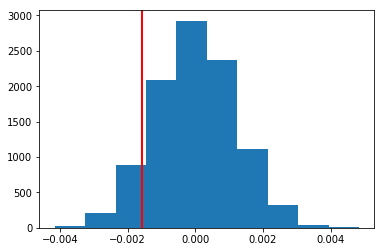

In [28]:
np_diffs=np.array(p_diffs)
plt.hist(np_diffs)
act_diff= converted_treat_porp-converted_control_porp
plt.axvline(act_diff, color='red', linewidth=2);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
#greater than actual difference 
greater_than_value=(np_diffs>act_diff).sum()/10000
print(greater_than_value)

0.9052


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### Since p-value is way larger than > 0.05 (0.9) We have no strong significant evidence to reject the null hypothesis. Which means there is almost no diffeencce between new page and old page. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm
convert_old = df2.query("group == 'control'")['converted'].sum()
convert_new = df2.query("group == 'treatment'")['converted'].sum()
n_old = Nold
n_new = Nnew
print(convert_old,n_old)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489 145274


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old],alternative='larger')
print(z_score,p_value)

-1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### p-value is the probability of the signifacity for the null, small p-value is indication of the unsigficance of accepting the null, while high p-value indicateds that it is more likely the null is true. we have here a high p-value score which indicates that it is unprobably the null is false. 
#### z-score is an indication for how far our data point is from the mean value and high z-score indicates that the null hypothesis is unlikely to be true, since we have relatively small z-score here (1.3), it indicates that we can't refuse the null hypothesis. 
#### the z-score and p-value matches with the findings earlier. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

As we have two options, is to determine weather it is converted or not, we will use logistic regression. 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('control',axis=1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
logistic_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
fitting = logistic_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
fitting.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-20 18:43 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

#### p-value is different from part two as we are performing a two tail test here, unlike the on tailed test we performed on part 2 . Our null hypothesis here is when ab_page is 0, converted is 1. Our alterntive is when ab_page is 1, converted is 1.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### since there is no evidence the group (landing page) effecting the conversion in any way, we need to consider another factor, they should be independet. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [35]:
country = pd.read_csv('countries.csv')
print(country.head())
df2_country = df2.set_index('user_id').join(country.set_index('user_id'))
print(df2_country.head())
print(df2_country['country'].unique())

   user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK
                          timestamp      group landing_page  converted  \
user_id                                                                  
851104   2017-01-21 22:11:48.556739    control     old_page          0   
804228   2017-01-12 08:01:45.159739    control     old_page          0   
661590   2017-01-11 16:55:06.154213  treatment     new_page          0   
853541   2017-01-08 18:28:03.143765  treatment     new_page          0   
864975   2017-01-21 01:52:26.210827    control     old_page          1   

         intercept  ab_page country  
user_id                              
851104           1        0      US  
804228           1        0      US  
661590           1        1      US  
853541           1        1      US  
864975           1        0      US  
['US' 'CA' 'UK']


In [36]:
df2_country[['CA', 'UK', 'US']] = pd.get_dummies(df2_country['country'])
df2_country.drop('US',axis=1)
logitstic_model2 = sm.Logit(df2_country['converted'], df2_country[['intercept','ab_page','UK','CA']])
fitting2 = logitstic_model2.fit()
fitting2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-20 18:43 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
==================================================================

"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
df2_country['CA_ab_page'] = df2_country['CA']*df2_country['ab_page']
df2_country['UK_ab_page'] = df2_country['UK']*df2_country['ab_page']
df2_country['US_ab_page'] = df2_country['US']*df2_country['ab_page']
logitistic_model3 = sm.Logit(df2_country['converted'], df2_country[['intercept','ab_page','CA_ab_page', 'UK_ab_page','UK',"US"]])
fitting3 = logitistic_model3.fit()
fitting3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-20 18:45 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0206    0.0137   -1.5052  0.1323  -0.0473   0.0062
CA_ab_page    -0.0469    0.0538   -0.8718  0.3833  -0.1523   0.0585
UK_ab_page     0.0314    0.0266    1.1807  0.2377  -0.0207   0.0835
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
==================================================================

"""

# Conclusion

In [47]:
odds_ratio_intercept=1/np.exp(-0.20040)
odds_ratio_ab_page=1/np.exp(-0.0206)
odds_ratio_CA_ab_page=1/np.exp(-0.0469)
print(odds_ratio_intercept,odds_ratio_ab_page,odds_ratio_CA_ab_page)
print(np.exp(fitting3.params))

1.22189141699 1.0208136445 1.04801720212
intercept     0.134794
ab_page       0.979646
CA_ab_page    0.954198
UK_ab_page    1.031896
UK            1.011854
US            1.017682
dtype: float64


### It's 1.22 less likely to convert when receiving an old page, 1.02 times less likely to convert when reciving new page in general, and 1.048 less llikely to convert for Canada residents. 

# Our final conclusion is that the company should not switch  to the new page, since there's no prcti signafcance that people who switched to the new page even when they recived it (treatment group). Running the expirement for longer period wouldn't effect the findings with much margin. 
# There's small statistical signficance for UK and US residents to convert into new page but it is not signficant practically. 


<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [83]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0